# Judicial Vacancies Data Source Exploration

This notebook demonstrates how to use the `dataset` module to fetch and process judicial vacancy data.

## Overview

We'll:
1. Fetch and process judicial vacancy data using the dataset module
2. Save the processed data for further analysis
3. Load the data and perform exploratory data analysis (e.g. visualizations)

## Setup

In [25]:
import sys
!{sys.executable} -m pip list | grep nomination_predictor

nomination_predictor      0.0.1             /home/wsl2ubuntuuser/nomination_predictor


In [26]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from typing import Optional, Tuple, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Import our data processing module
from nomination_predictor import dataset
from nomination_predictor.config import RAW_DATA_DIR, PROCESSED_DATA_DIR

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Verify the data directory exists and is writable
if not RAW_DATA_DIR.exists():
    print(f"Error: Data directory does not exist: {RAW_DATA_DIR}")
elif not os.access(RAW_DATA_DIR, os.W_OK):
    print(f"Error: No write permission for directory: {RAW_DATA_DIR}")
else:
    print(f"Data directory is ready: {RAW_DATA_DIR}")

Data directory is ready: /home/wsl2ubuntuuser/nomination_predictor/data/raw


## 1. Fetch and Process Data

Let's fetch the data for the range of available years and process it.

In [ ]:
YEARS_BACK = 16
raw_combined_csv_path = RAW_DATA_DIR / "judicial_data.csv"
raw_vacancies_csv_path = RAW_DATA_DIR / "judicial_vacancies.csv"
raw_confirmations_csv_path = RAW_DATA_DIR / "judicial_confirmations.csv"
raw_emergencies_csv_path = RAW_DATA_DIR / "judicial_emergencies.csv"

In [ ]:
def load_judicial_data(
        years_back: int = YEARS_BACK,
        force_refresh: bool = False,
        output_dir: Path = RAW_DATA_DIR,
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Load judicial data from already-saved CSV file if it is found; if not found (or if refresh forced via input arg), uses dataset module to re-retrieve from Internet into new dataframes.
        Does not attempt to save new CSV files with those dataframes; see save_judicial_data() for that.
        
        Args:
            years_back: Number of years of historical data to fetch
            force_refresh: If True, force refetching data even if files exist
            output_dir: Directory to save/load data files
            
        Returns:
            Tuple of (vacancies_df, confirmations_df, emergencies_df, combined_df)
        """
        
        try:
            # Only run the pipeline if output doesn't exist or force_refresh is True
            if force_refresh or not raw_combined_csv_path.exists():
                print("Running data pipeline...")
                with tqdm(total=4, desc="Processing data") as progress_bar:
                    # Run the main data pipeline
                    combined_df = dataset.main(
                        output_dir=output_dir,
                        output_filename=raw_combined_csv_path.name,
                        years_back=years_back
                    )
                    progress_bar.update(1)

                    
                    # Read the data with progress
                    progress_bar.set_description("Loading individual datasets")
                    combined_df = pd.read_csv(raw_combined_csv_path, sep='|') if raw_combined_csv_path.exists() else pd.DataFrame()
                    progress_bar.update(1)
                    
                    vacancies_df = pd.read_csv(raw_vacancies_csv_path, sep='|') if raw_vacancies_csv_path.exists() else pd.DataFrame()
                    progress_bar.update(1)
                    
                    confirmations_df = pd.read_csv(raw_confirmations_csv_path, sep='|') if raw_confirmations_csv_path.exists() else pd.DataFrame()
                    emergencies_df = pd.read_csv(raw_emergencies_csv_path, sep='|') if raw_emergencies_csv_path.exists() else pd.DataFrame()
                    progress_bar.update(1)
                    
            else:
                print("Loading cached data...")
                combined_df = pd.read_csv(raw_combined_csv_path, sep='|') if raw_combined_csv_path.exists() else pd.DataFrame()
                vacancies_df = pd.read_csv(raw_vacancies_csv_path, sep='|') if raw_vacancies_csv_path.exists() else pd.DataFrame()
                confirmations_df = pd.read_csv(raw_confirmations_csv_path, sep='|') if raw_confirmations_csv_path.exists() else pd.DataFrame()
                emergencies_df = pd.read_csv(raw_emergencies_csv_path, sep='|') if raw_emergencies_csv_path.exists() else pd.DataFrame()
                
            return vacancies_df, confirmations_df, emergencies_df, combined_df
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [ ]:
import os
from pathlib import Path

import pandas as pd

data_file = Path(raw_combined_csv_path)
data_refreshed: bool = False

# Check if file exists and is not empty
if data_file.exists() and os.path.getsize(data_file) > 0:
    print("Loading existing judicial data...")
    vacancies_df, confirmations_df, emergencies_df, combined_df = load_judicial_data(
        years_back=YEARS_BACK,
        force_refresh=False  # Use existing data
    )
else:
    print("No existing data found or file is empty. Fetching fresh data...")
    vacancies_df, confirmations_df, emergencies_df, combined_df = load_judicial_data(
        years_back=YEARS_BACK,
        force_refresh=True  # Force fetch new data
    )
    data_refreshed = True

Loading existing judicial data...
Loading cached data...


## 2. Save raw Data

Save the raw data to a CSV file in the `data/raw` directory.

In [ ]:
# Save dataframes to csv files if we got new data
from nomination_predictor.dataset import save_dataframe_to_csv

if data_refreshed and (combined_df is not None) and not combined_df.empty:
    save_dataframe_to_csv(combined_df, "judicial_data", RAW_DATA_DIR)
        
    # Save individual processed datasets
    if not vacancies_df.empty:
        save_dataframe_to_csv(vacancies_df, "judicial_vacancies", RAW_DATA_DIR)
    if not confirmations_df.empty:
        save_dataframe_to_csv(confirmations_df, "judicial_confirmations", RAW_DATA_DIR)
    if not emergencies_df.empty:
        save_dataframe_to_csv(emergencies_df, "judicial_emergencies", RAW_DATA_DIR)

## 3. Load and Explore the Saved Data

Let's verify that we can load the saved data.

In [ ]:
# Load the data\n",
print("Loading judicial data...")
vacancies_df, confirmations_df, emergencies_df, combined_df = load_judicial_data(
    years_back=YEARS_BACK,
    force_refresh=False  # Set to True to refetch data
)

Loading judicial data...
Loading cached data...


In [ ]:
# Display data summary
def display_data_summary():
    """Display summary of loaded data."""
    print("\nData Summary:")
    print(f"Vacancies: {len(vacancies_df)} records")
    print(f"Confirmations: {len(confirmations_df)} records")
    print(f"Emergencies: {len(emergencies_df)} records")
    print(f"Combined: {len(combined_df)} total records")
    
    if not combined_df.empty:
        print("\nDate ranges:")
        for col in ['vacancy_date', 'nomination_date', 'confirmation_date']:
            if col in combined_df.columns:
                dates = pd.to_datetime(combined_df[col], errors='coerce')
                valid_dates = dates[dates.notna()]
                if not valid_dates.empty:
                    print(f"{col}: {valid_dates.min().date()} to {valid_dates.max().date()}")

display_data_summary()


Data Summary:
Vacancies: 17068 records
Confirmations: 8859 records
Emergencies: 6813 records
Combined: 32740 total records

Date ranges:
vacancy_date: 1994-07-31 to 2025-05-31
nomination_date: 2009-03-17 to 2025-06-23
confirmation_date: 2009-09-17 to 2024-12-20


In [ ]:
# trim & normalize string column names
for df in (vacancies_df, confirmations_df, emergencies_df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    str_cols = df.select_dtypes(include=['object']).columns
    df[str_cols] = df[str_cols].apply(lambda x: x.str.strip().str.lower())

It'll be easier to perform data analysis if we we'll have to convert dates from string to datetime format. in order for that to work, we'll need to clean up one item clearly-incorrect in the source data: despite the Vacancy Confirmations report from 2015 January showing Claudia Ann Wilken assumed senior status in January 1st of the year 3000, according to https://www.fjc.gov/node/1389756 it really happened on December 17th, 2014 instead.  We'll correct for that in order for pd.to_datetime() to not choke on a far-future year...

In [ ]:
confirmations_df.loc[confirmations_df['incumbent'] == 'Wilken,Claudia', 'vacancy_date'] = '12/17/2014'

Parse dates to convert any yyyy/mm/dd, mm/dd/yyyy, or empty string to datetime64[ns]:

In [ ]:
for df in (vacancies_df, confirmations_df, emergencies_df):
    if df is not None and not df.empty:
        df['vacancy_date'] = pd.to_datetime(df['vacancy_date'], errors='coerce')

if vacancies_df is not None and not vacancies_df.empty:
    vacancies_df['nomination_date'] = pd.to_datetime(vacancies_df['nomination_date'], errors='coerce')
        
if confirmations_df is not None and not confirmations_df.empty: 
    confirmations_df['confirmation_date'] = pd.to_datetime(confirmations_df['confirmation_date'], errors='coerce')

Split the “circuit-court” code into two columns (circuit, district_or_state) so “02 – NYS” and “02 – NYW” group sensibly:

In [ ]:
from nomination_predictor.dataset import parse_circuit_court


# Function to safely parse circuit and court
def add_circuit_court_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add 'circuit' and 'court_code' columns to the dataframe by parsing the source column.
    
    Args:
        df: Input DataFrame
        source_col: Name of the column containing the court string to parse
        
    Returns:
        DataFrame with added 'circuit' and 'court_code' columns
    """
    # Initialize new columns
    df['circuit'] = None
    df['court_code'] = None
    
    # Parse each court string and fill the new columns
    for idx, court_str in df['circuit_district'].items():
        try:
            circuit, court_code = parse_circuit_court(str(court_str))
            df.at[idx, 'circuit'] = circuit
            df.at[idx, 'court_code'] = court_code
        except ValueError as e:
            print(f"Warning: Could not parse court string '{court_str}': {e}")
            df.at[idx, 'circuit'] = None
            df.at[idx, 'court_code'] = court_str  # Keep original as fallback
    
    return df

In [ ]:
# rename the differently-named, same-purpose column from vacancies tables to make looping easier:
if not vacancies_df.empty and 'court' in vacancies_df.columns:
    vacancies_df = vacancies_df.rename(columns={'court': 'circuit_district'})

for df_name, df in [('vacancies_df', vacancies_df), ('confirmations_df', confirmations_df), ('emergencies_df', emergencies_df)]:
    if not df.empty:
        print(f"\nAdding circuit/court columns to {df_name}")
        df = add_circuit_court_columns(df)
        display(df[['circuit_district', 'circuit', 'court_code']].head())


Adding circuit/court columns to vacancies_df


,circuit_district,circuit,court_code
0,01 - CCA,1,CCA
1,01 - MA,1,MA
2,01 - RI,1,RI
3,02 - CCA,2,CCA
4,02 - NYE,2,NYE



Adding circuit/court columns to confirmations_df


,circuit_district,circuit,court_code
0,02 - NYS,2,NYS
1,02 - CCA,2,CCA
2,08 - SD,8,SD
3,02 - CCA,2,CCA
4,04 - CCA,4,CCA



Adding circuit/court columns to emergencies_df


,circuit_district,circuit,court_code
0,01 - CCA,1,CCA
1,02 - NYW,2,NYW
2,02 - CCA,2,CCA
3,03 - DE,3,DE
4,03 - CCA,3,CCA


Normalize humans' names to make for more consistent dataframe joins

In [ ]:
vacancies_df['incumbent'] = vacancies_df['incumbent'].str.upper()
emergencies_df['vacancy_created_by'] = emergencies_df['vacancy_created_by'].str.upper()
confirmations_df['nominee'] = confirmations_df['nominee'].str.upper()

### Creating a *seat-vacancy key* for ourselves

A vacancy can be uniquely defined by a consistent combination of circuit, court district, incumbent (or in the case of newly-opened roles, the lack of an incumbent), and vacancy date.  Over time it typically gets a nominee, then gets a confirmation. But those are a matter of its status or progress over time; the vacancy ID we'd give it would stay the same across months to indicate it's the same vacancy.

The seat_id can end up looking something like:
`seat_id:str = (circuit|court_code|incumbent|vacancy_date).casefold()`

In [ ]:
# after loading the emergencies dataframe, standardize the column name to be same as the way the other dataframes use that info
if not emergencies_df.empty and 'vacancy_created_by' in emergencies_df.columns:
    emergencies_df = emergencies_df.rename(columns={'vacancy_created_by': 'incumbent'})

# standardizing incumbent name column makes 
def make_key(df) -> str:
    # Use the new circuit and court_code columns instead of circuit_district because we just engineered the former pair to be more consistent across dataframes
    circuit_info = df['circuit'].astype(str) + '-' + df['court_code'].fillna('')
    return (
        circuit_info
        + "|" + df['incumbent'].fillna("POSITION OPEN")
        + "|" + df['vacancy_date'].dt.strftime("%Y-%m-%d")
    ).casefold()

vacancies_df['seat_id'] = make_key(vacancies_df)
vacancies_df['seat_id']  = make_key(vacancies_df)
emergencies_df['seat_id'] = make_key(emergencies_df)
confirmations_df['seat_id'] = make_key(confirmations_df)

De-duplicate monthly re-listings

In [63]:
# Process each dataframe to keep only the most recent entry for each seat_id
for df_name in ['vacancies_df', 'confirmations_df', 'emergencies_df']:
    if df_name in locals() and not locals()[df_name].empty:
        print(f"\nProcessing {df_name}...")
        df = locals()[df_name]
        
        # Store original row count for reporting
        original_count = len(df)
        
        # Create a datetime column for proper date comparison
        df['source_date'] = pd.to_datetime(
            df['source_year'].astype(str) + '-' + 
            df['source_month'].astype(str).str.zfill(2) + '-01'
        )
        
        # Sort by seat_id and source_date in descending order
        # Then drop duplicates, keeping the first (most recent) occurrence of each seat_id
        df_clean = (df
                   .sort_values(['seat_id', 'source_date'], ascending=[True, False])
                   .drop_duplicates('seat_id', keep='first'))
        
        # Remove the temporary column
        df_clean = df_clean.drop('source_date', axis=1)
        
        # Update the original dataframe
        locals()[df_name] = df_clean
        
        # Report the number of duplicates removed
        print(f"  - Original rows: {original_count}")
        print(f"  - Unique seat_ids: {len(df_clean)}")
        print(f"  - Duplicates removed: {original_count - len(df_clean)}")
    else:
        print(f"\nSkipping {df_name} - not found or empty")


Processing vacancies_df...
  - Original rows: 17068
  - Unique seat_ids: 907
  - Duplicates removed: 16161

Processing confirmations_df...
  - Original rows: 8859
  - Unique seat_ids: 861
  - Duplicates removed: 7998

Processing emergencies_df...
  - Original rows: 6813
  - Unique seat_ids: 408
  - Duplicates removed: 6405


## After combining datasets?

In [ ]:
if combined_df is not None:
    print("\nSample data from combined dataset:")
    display(combined_df.head())
    
    # Basic statistics
    print("\nBasic Statistics:")
    
    if 'vacancy_date' in combined_df.columns:
        print("\nDate Range:")
        # Convert from string to datetime so that comparisons actually compare
        combined_df['vacancy_date_dt'] = pd.to_datetime(combined_df['vacancy_date'], format='%m/%d/%Y')
        print(f"Earliest vacancy: {combined_df['vacancy_date_dt'].min().strftime('%m/%d/%Y')}")
        print(f"Latest vacancy: {combined_df['vacancy_date_dt'].max().strftime('%m/%d/%Y')}")
        
    print('\nRecords per year:')
    print(combined_df['source_year'].value_counts().sort_index())
    
    if 'circuit_district' in combined_df.columns:
        print("\nRecords by Circuit/District:")
        print(combined_df['circuit_district'].value_counts().head(10))
        


Sample data from combined dataset:


,court,incumbent,vacancy_reason,vacancy_date,source_year,source_month,source_page_type,nominee,nomination_date,confirmation_date,circuit_district,title,vacancy_created_by,reason,days_pending,weighted,adjusted,vacancy_date_dt
0,01 - CCA,"Selya,Bruce M.",Senior,2006-12-31,2009,7,vacancies,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-31
1,01 - MA,"Lindsay,Reginald C.",Deceased,2009-03-12,2009,7,vacancies,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-03-12
2,01 - RI,"Torres,Ernest C.",Senior,2006-12-01,2009,7,vacancies,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-01
3,02 - CCA,"Straub,Chester J.",Senior,2008-07-16,2009,7,vacancies,"Lynch,Gerard E.",2009-04-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-07-16
4,02 - NYE,"Gershon,Nina",Senior,2008-10-16,2009,7,vacancies,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-10-16



Basic Statistics:

Date Range:
Earliest vacancy: 07/31/1994
Latest vacancy: 05/31/2025

Records per year:
source_year
2009     730
2010    2078
2011    1942
2012    2120
2013    1802
2014    2205
2015    1172
2016    1686
2017    2280
2018    3159
2019    2876
2020    2878
2021    1594
2022    2100
2023    1629
2024    2013
2025     476
Name: count, dtype: int64

Records by Circuit/District:
circuit_district
09 - CCA     598
03 - NJ      528
09 - CA-C    470
02 - NYS     386
02 - CCA     355
09 - AZ      341
05 - CCA     337
05 - TXS     330
11 - CCA     288
09 - CAN     286
Name: count, dtype: int64



Exploring Vacancies data:

First few records:


,court,incumbent,vacancy_reason,vacancy_date,source_year,source_month,source_page_type,nominee,nomination_date
0,01 - CCA,"Selya,Bruce M.",Senior,12/31/2006,2009,7,vacancies,NaN,NaN
1,01 - MA,"Lindsay,Reginald C.",Deceased,03/12/2009,2009,7,vacancies,NaN,NaN
2,01 - RI,"Torres,Ernest C.",Senior,12/01/2006,2009,7,vacancies,NaN,NaN
3,02 - CCA,"Straub,Chester J.",Senior,07/16/2008,2009,7,vacancies,"Lynch,Gerard E.",04/02/2009
4,02 - NYE,"Gershon,Nina",Senior,10/16/2008,2009,7,vacancies,NaN,NaN


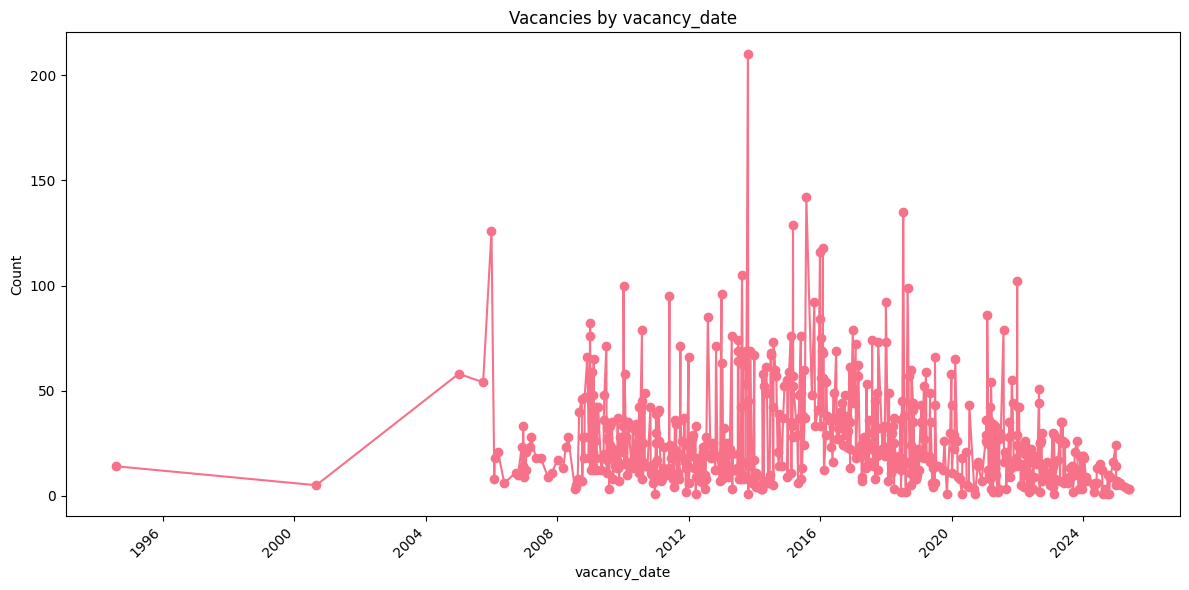

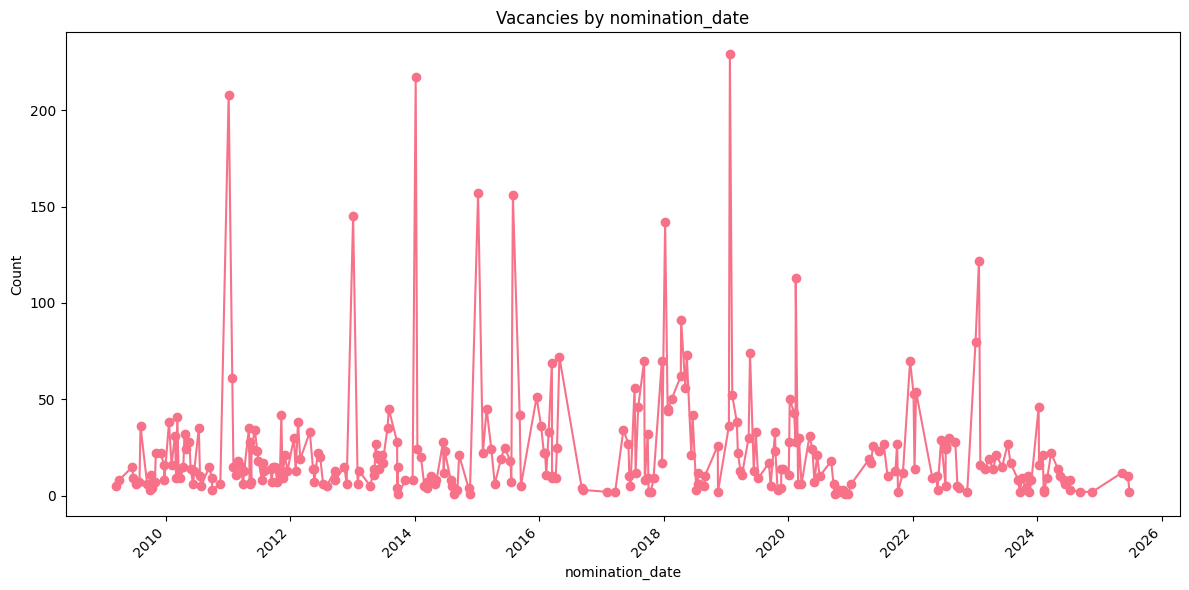

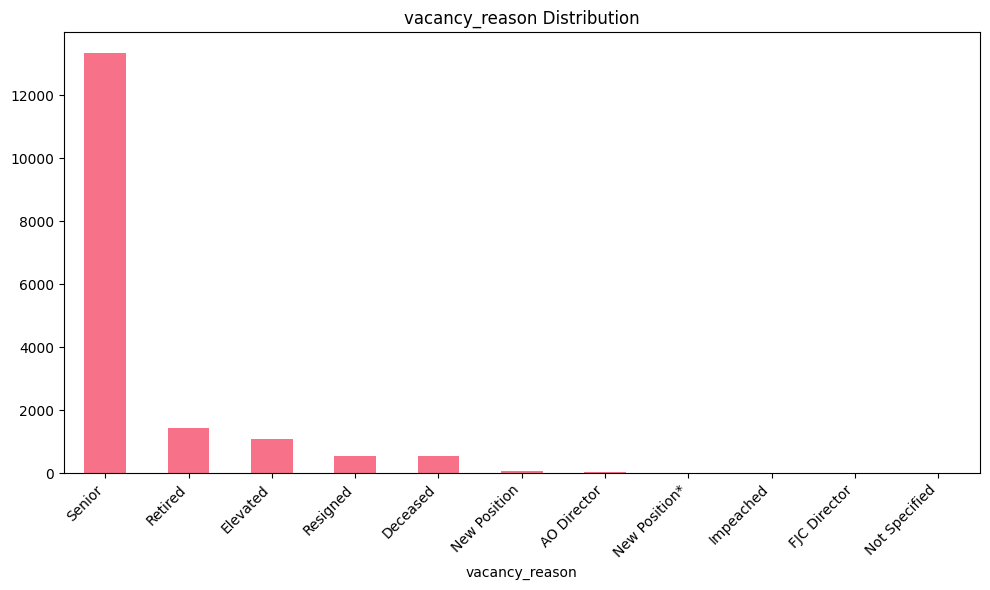

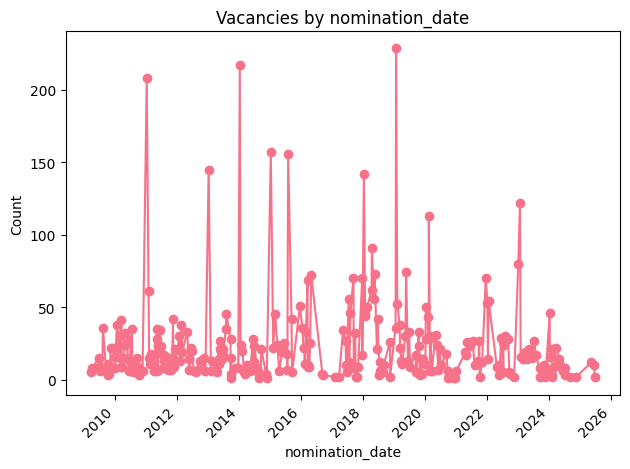

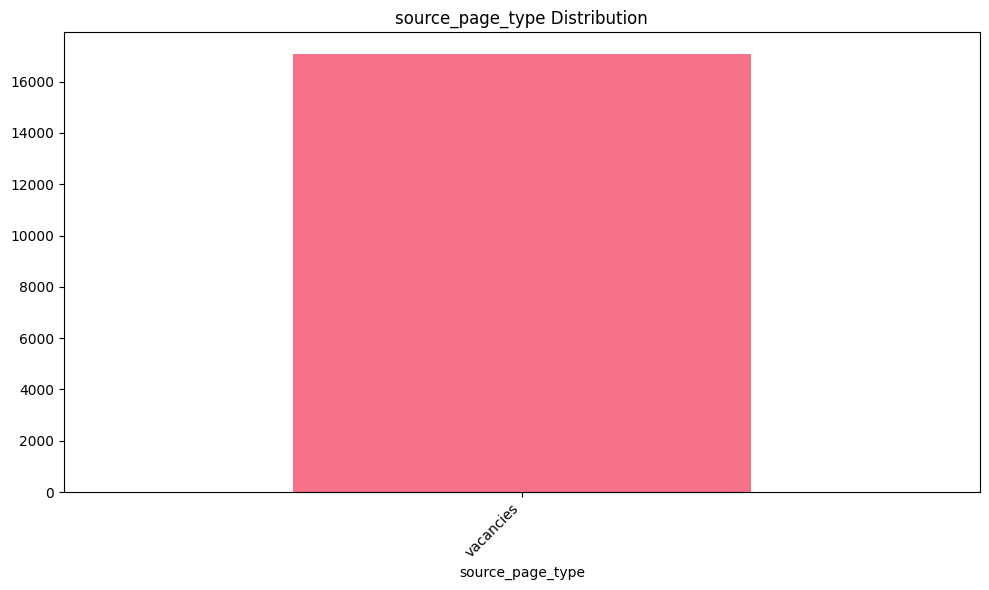

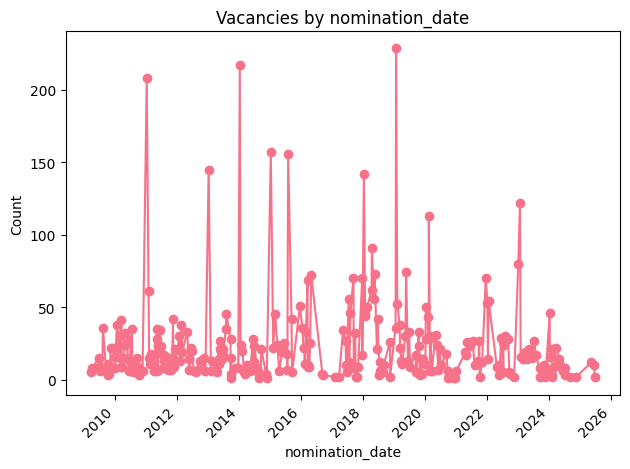

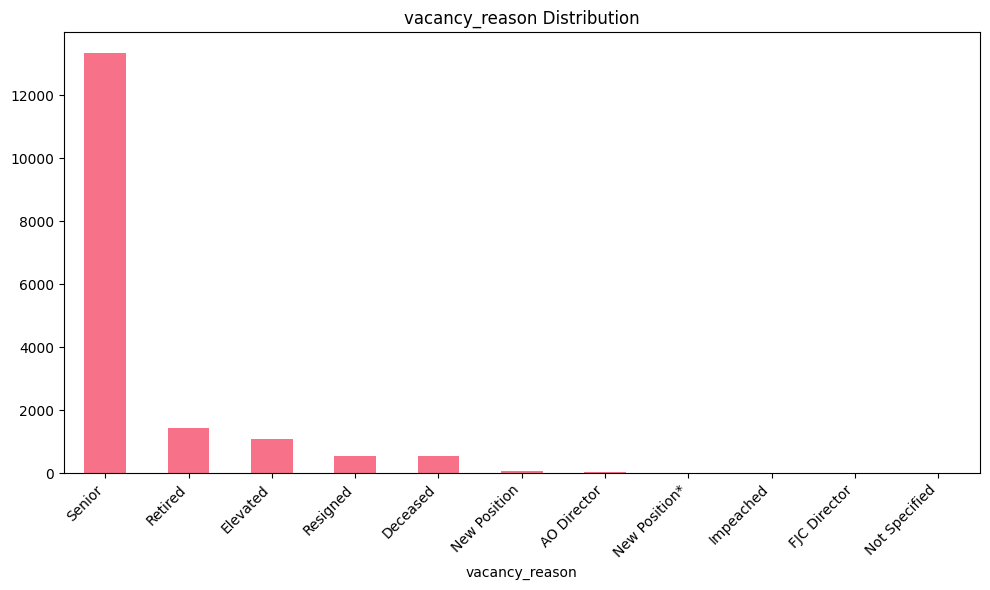

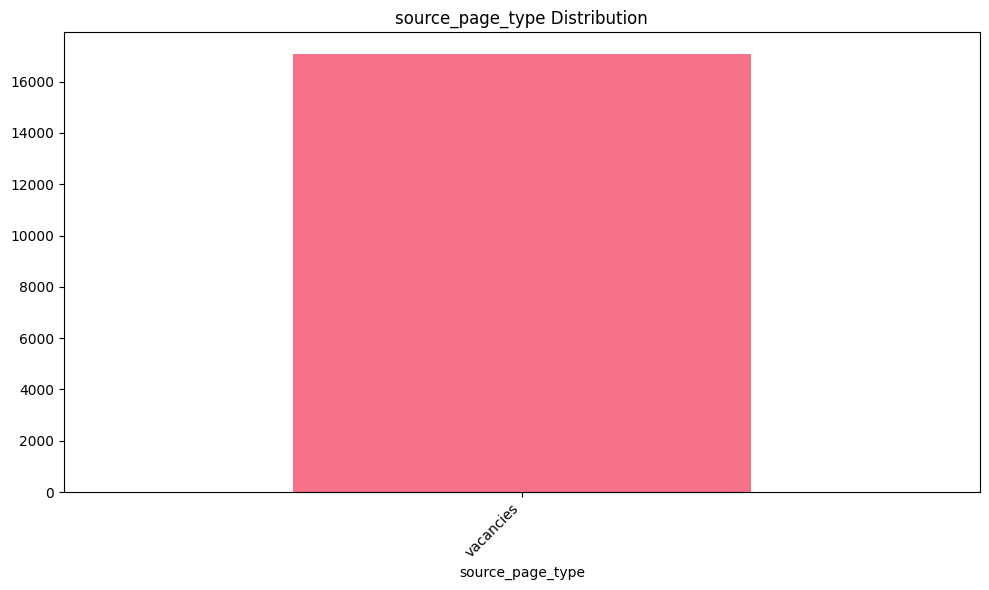


Exploring Confirmations data:

First few records:


,nominee,nomination_date,confirmation_date,circuit_district,incumbent,vacancy_date,vacancy_reason,source_year,source_month,source_page_type
0,"Lynch,Gerard E. (103419)",04/02/2009,09/17/2009,02 - NYS,NaN,NaN,NaN,2009,10,confirmations
1,"Lynch,Gerard E.",04/02/2009,09/17/2009,02 - CCA,"Straub,Chester J.",07/16/2008,Senior,2009,11,confirmations
2,"Viken,Jeffrey L.",06/25/2009,09/29/2009,08 - SD,Position Open,NaN,NaN,2009,11,confirmations
3,"Lynch,Gerard E.",04/02/2009,09/17/2009,02 - CCA,"Straub,Chester J.",07/16/2008,Senior,2009,12,confirmations
4,"Davis,Andre M.",04/02/2009,11/09/2009,04 - CCA,Position Open,NaN,NaN,2009,12,confirmations


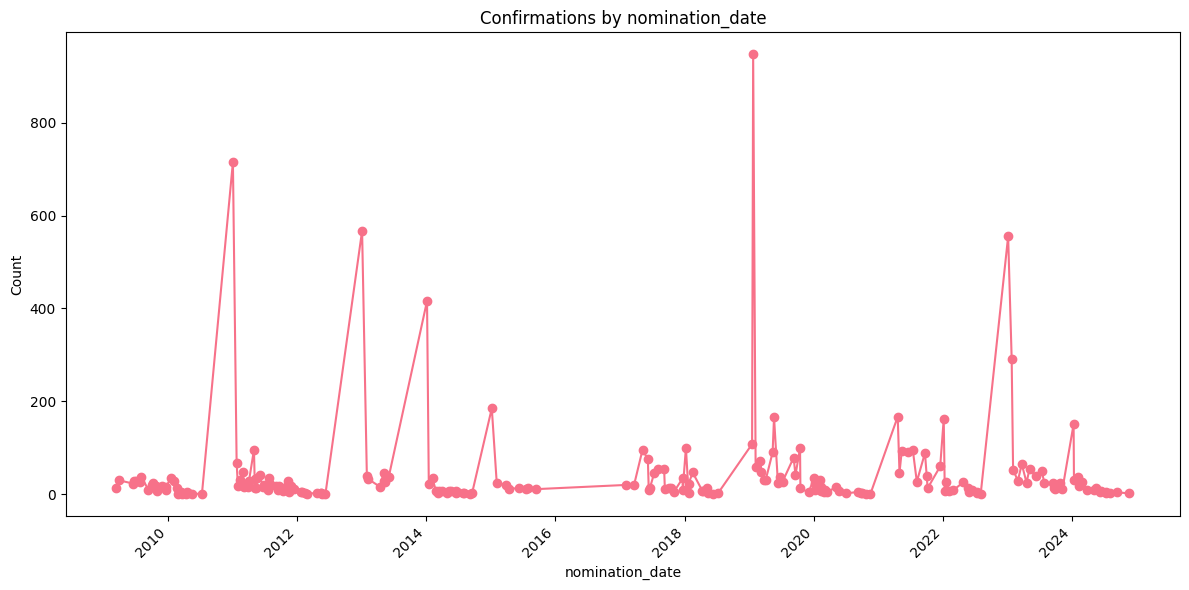

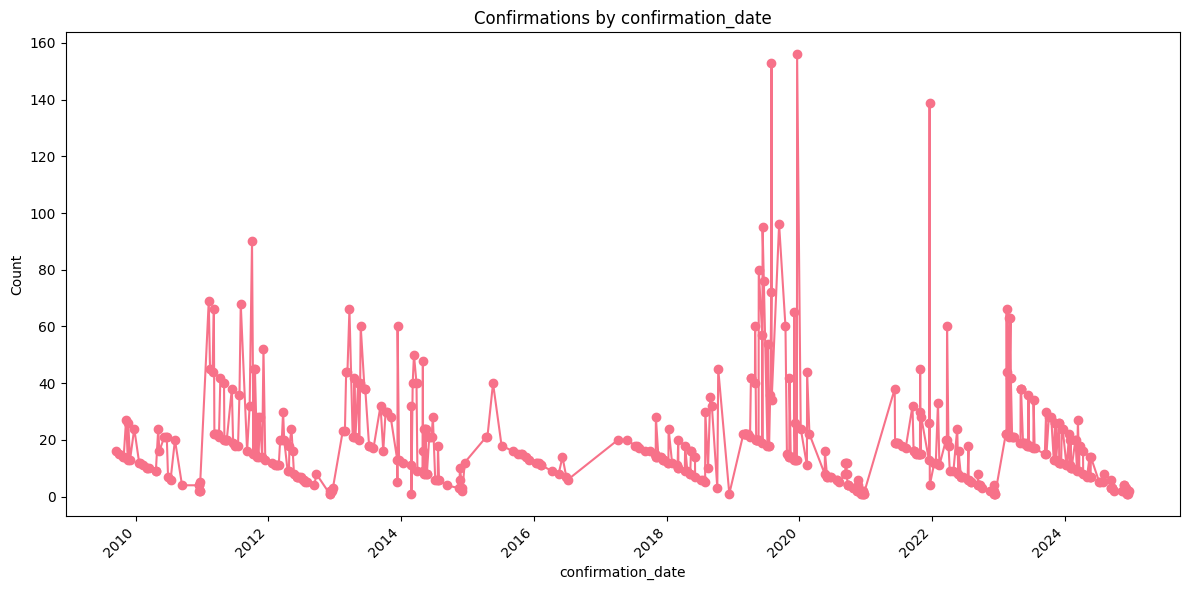

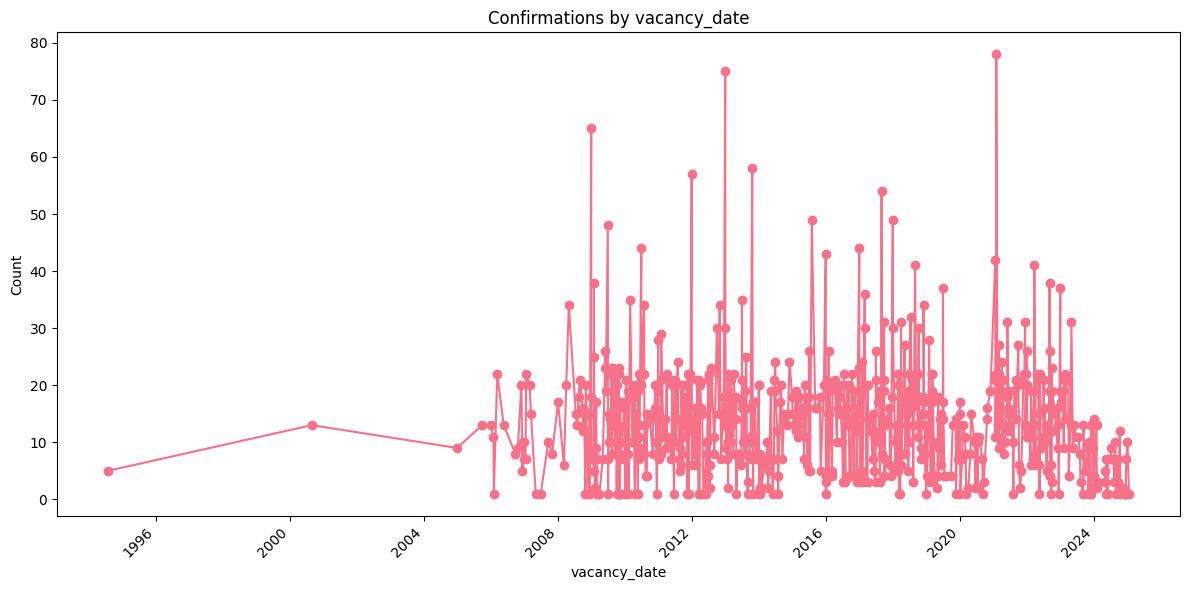

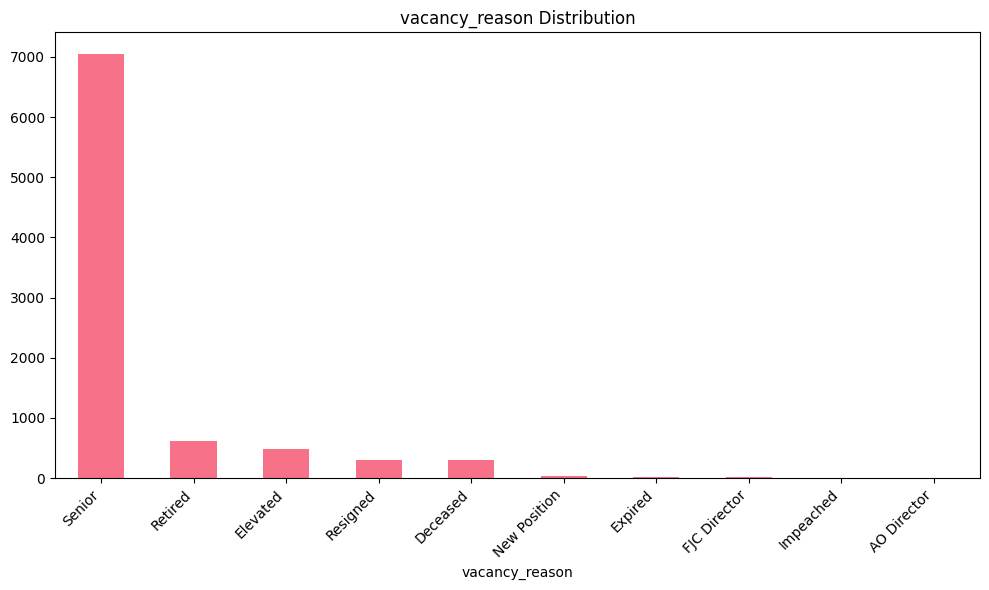

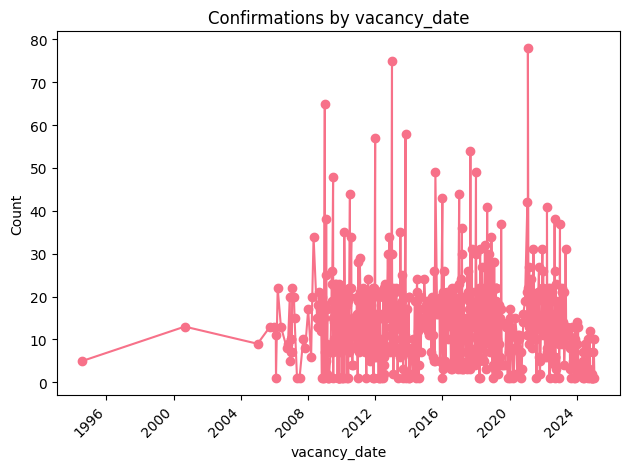

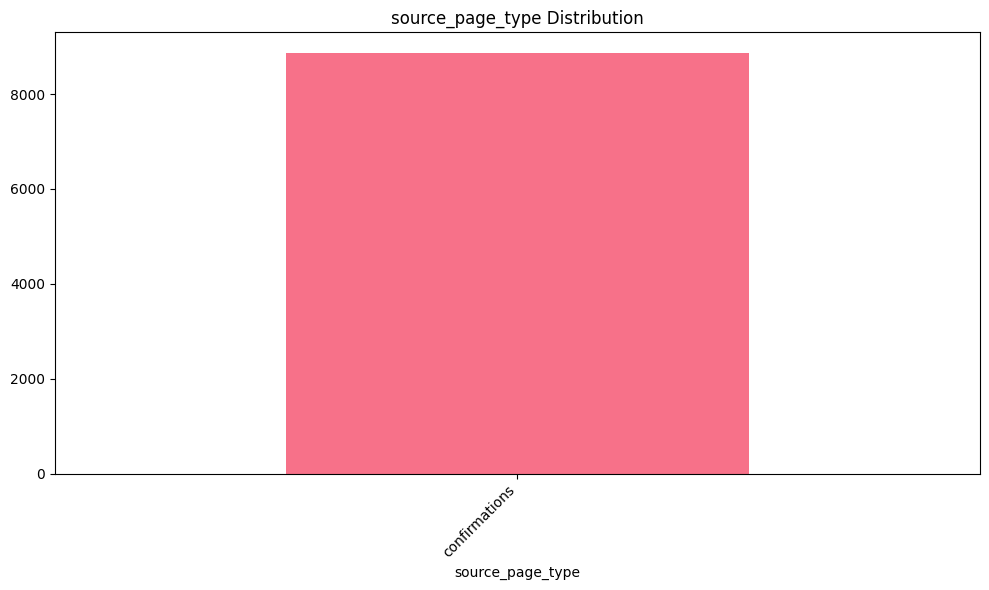

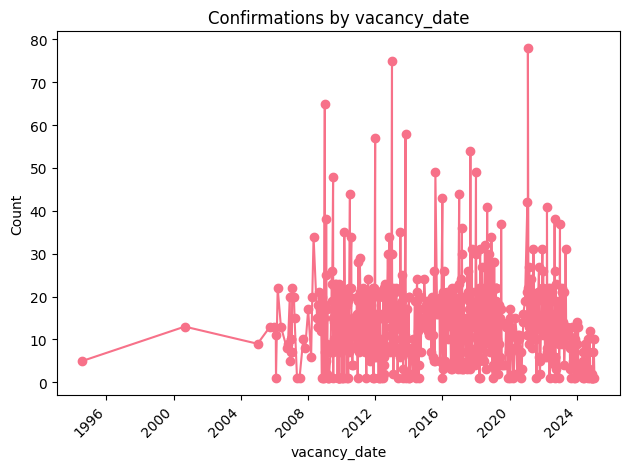

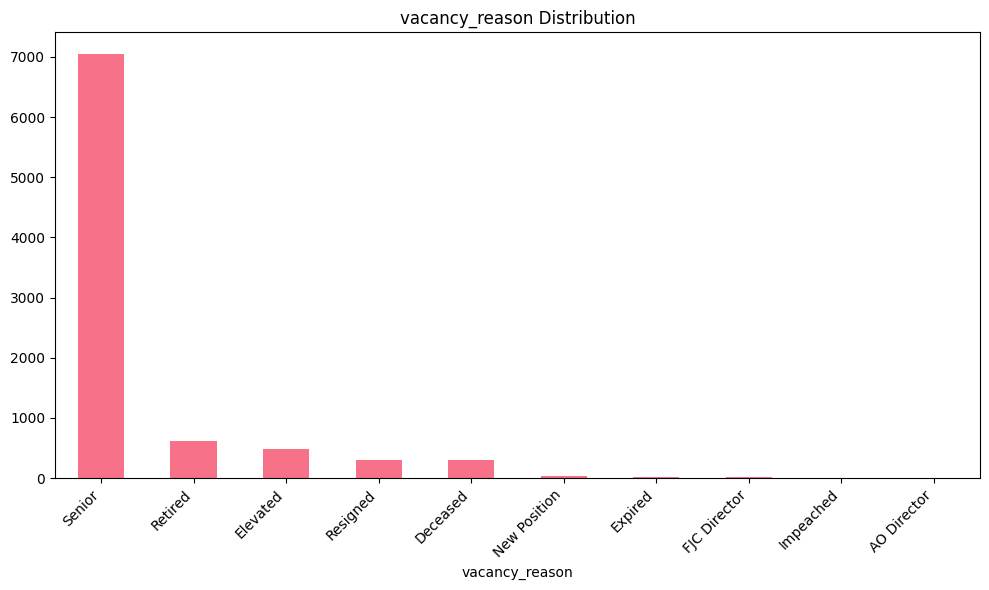

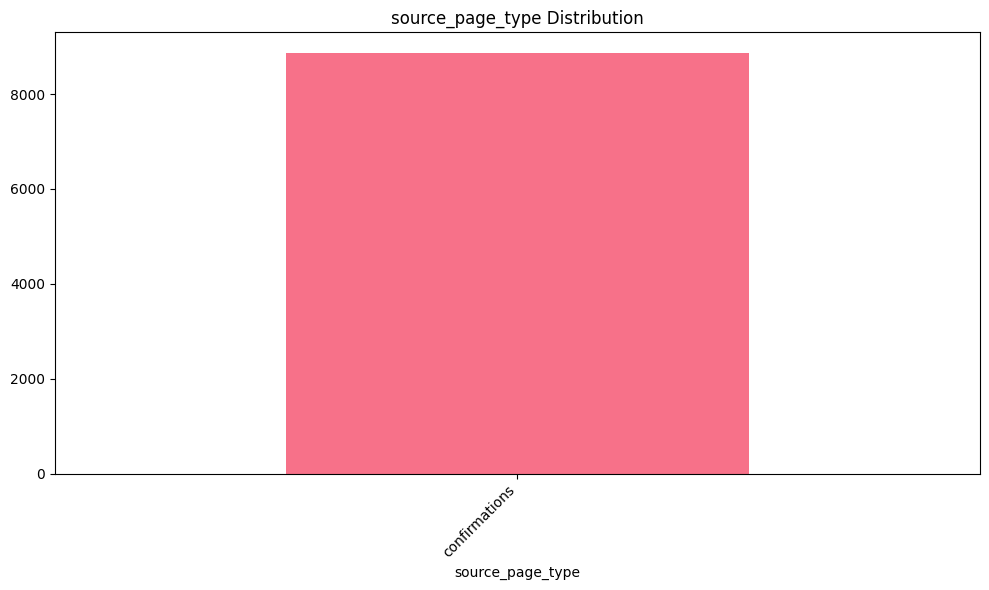


Exploring Emergencies data:

First few records:


,circuit_district,title,vacancy_created_by,reason,vacancy_date,days_pending,weighted,adjusted,source_year,source_month,source_page_type
0,01 - CCA,Circuit Judge,"Selya,Bruce M.",Senior,12/31/2006,913,NaN,624.0,2009,7,emergencies
1,02 - NYW,District Judge,"Larimer,David G.",Senior,03/03/2009,120,602.0,NaN,2009,7,emergencies
2,02 - CCA,Circuit Judge,"Straub,Chester J.",Senior,07/16/2008,350,NaN,1135.0,2009,7,emergencies
3,03 - DE,District Judge,"Jordan,Kent A.",Elevated,12/13/2006,931,441.0,NaN,2009,7,emergencies
4,03 - CCA,Circuit Judge,"Van Antwerpen,Franklin S.",Senior,10/23/2006,982,NaN,587.0,2009,7,emergencies


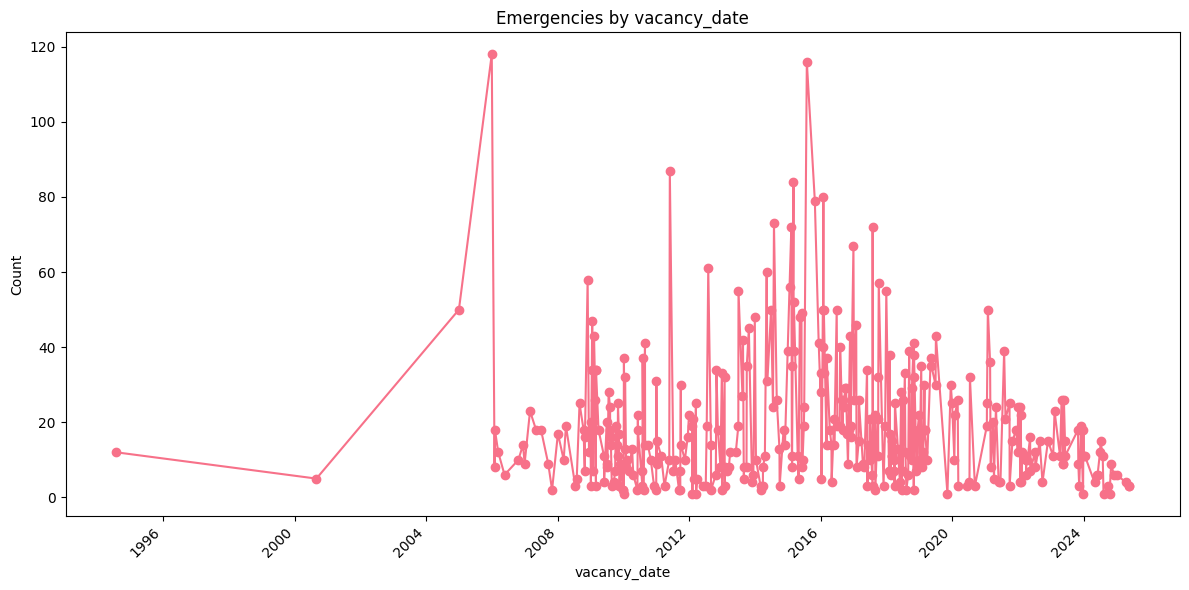

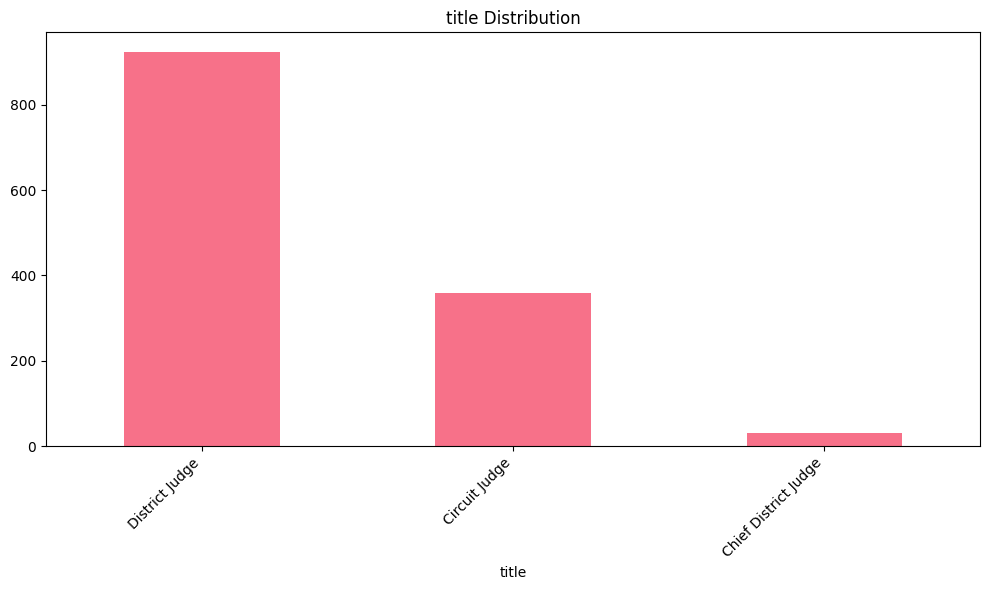

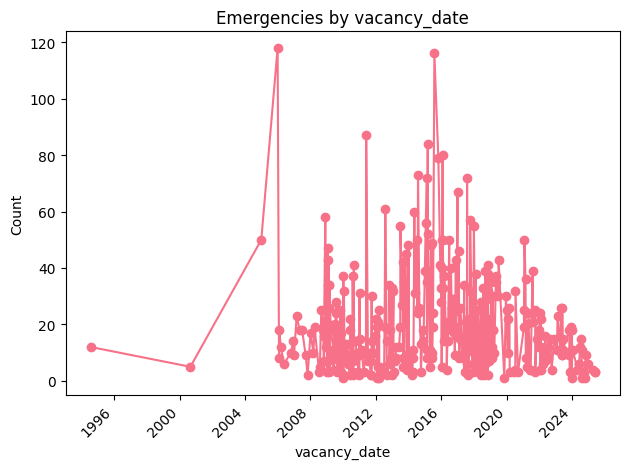

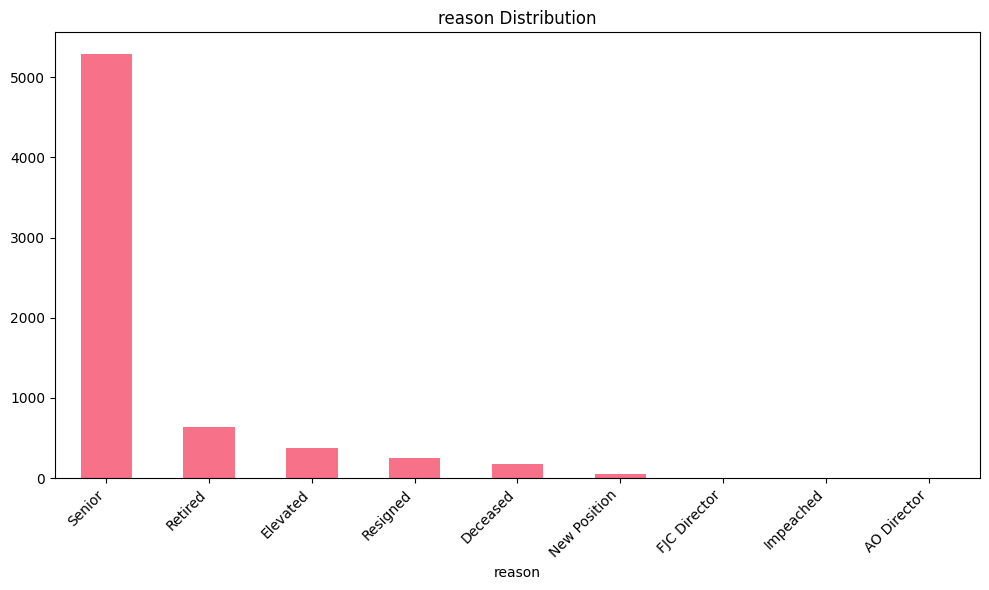

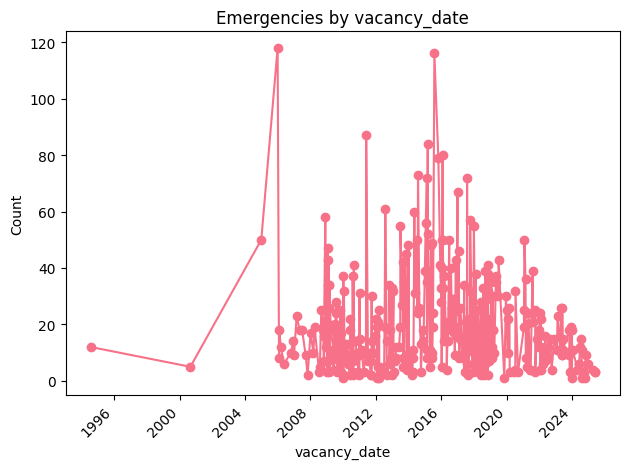

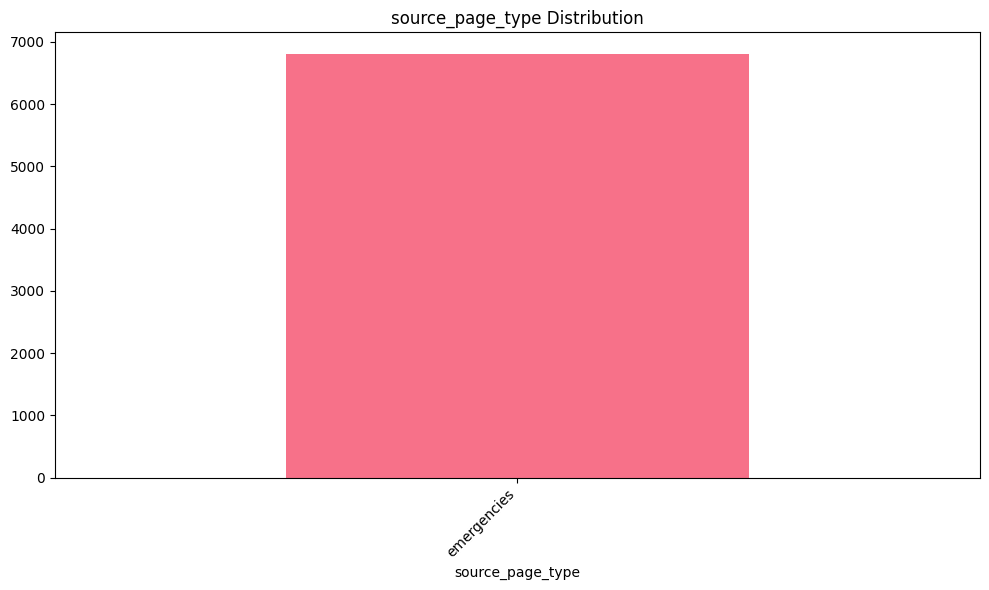

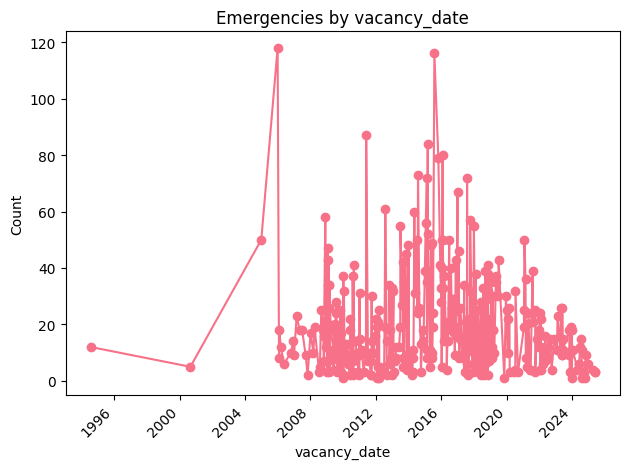

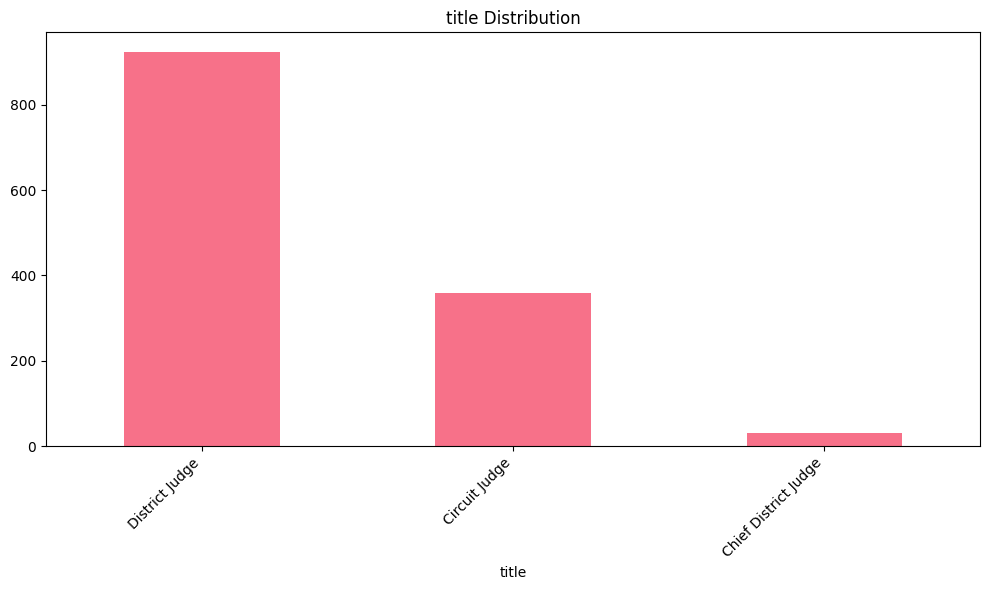

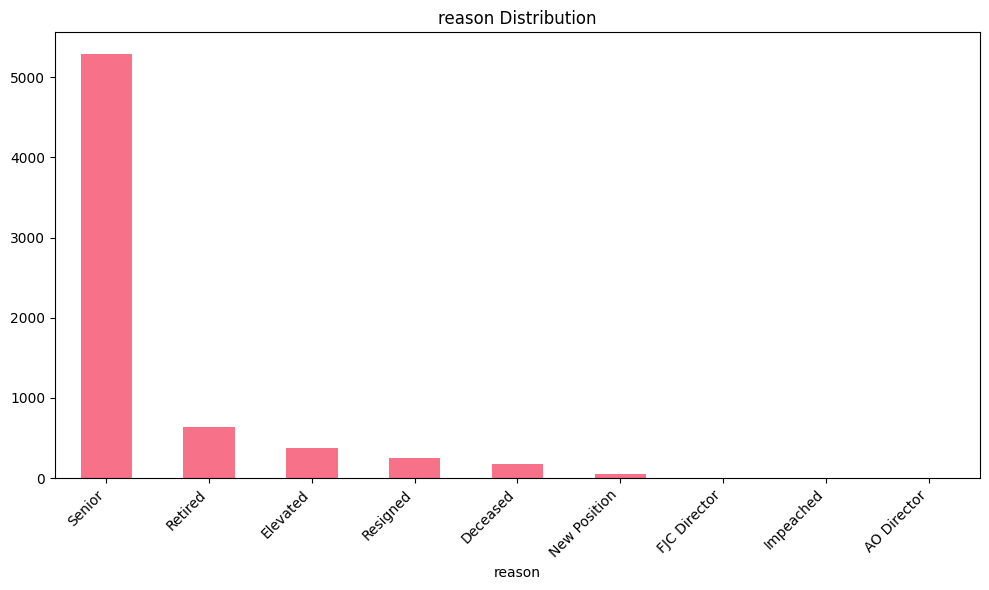

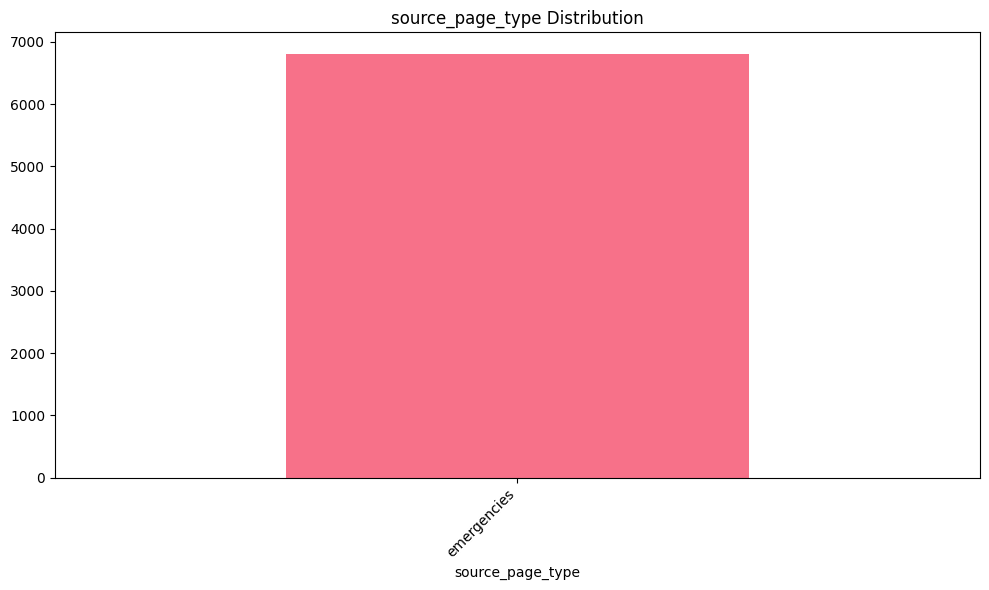

In [ ]:
def explore_data(df: pd.DataFrame, dataset_name: str) -> None:
    """
    Generate exploratory visualizations for a dataset.
    
    Args:
        df: DataFrame to explore
        dataset_name: Name of the dataset for titles
    """
    if df.empty:
        print(f"No data available for {dataset_name}")
        return
    
    print(f"\nExploring {dataset_name} data:")
    
    # Display basic info
    print("\nFirst few records:")
    display(df.head())
    
    # Plot time series if date columns exist
    date_columns = [col for col in df.columns if 'date' in col.lower()]
    for date_col in date_columns:
        if date_col in df.columns and not df[date_col].isna().all():
            plt.figure(figsize=(12, 6))
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            time_series = df[date_col].dropna().value_counts().sort_index()
            time_series.plot(kind='line', marker='o')
            plt.title(f"{dataset_name} by {date_col}")
            plt.xlabel(date_col)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # Plot categorical data
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() < 20]
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().sort_values(ascending=False).plot(kind='bar')
        plt.title(f"{col} Distribution")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        time_series = df[date_col].dropna().value_counts().sort_index()
        time_series.plot(kind='line', marker='o')
        plt.title(f"{dataset_name} by {date_col}")
        plt.xlabel(date_col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Plot categorical data
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() < 20]
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().sort_values(ascending=False).plot(kind='bar')
        plt.title(f"{col} Distribution")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Explore each dataset
if not vacancies_df.empty:
    explore_data(vacancies_df, "Vacancies")
    
if not confirmations_df.empty:
    explore_data(confirmations_df, "Confirmations")
    
if not emergencies_df.empty:
    explore_data(emergencies_df, "Emergencies")


Combined Data Analysis:


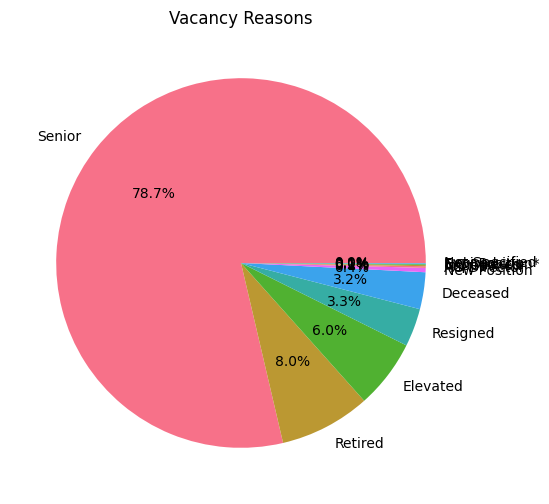

/tmp/ipykernel_39685/1346455338.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  combined_df.set_index('vacancy_date').resample('M').size().plot()


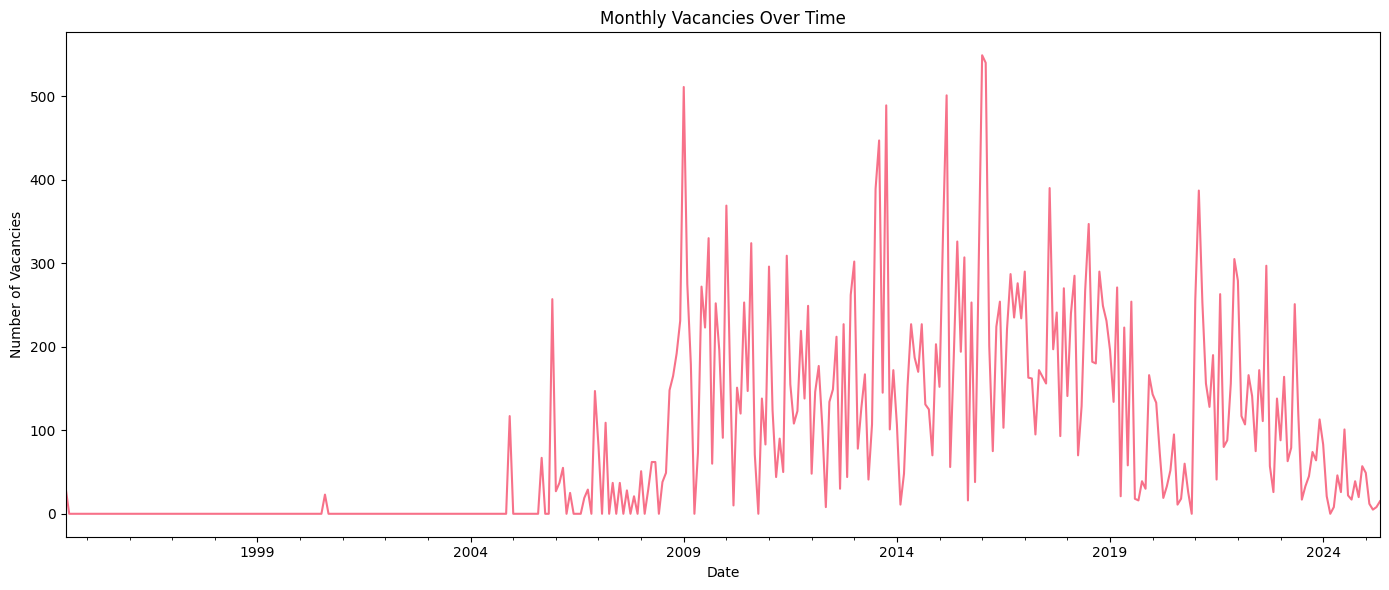

In [ ]:
if not combined_df.empty:
    print("\nCombined Data Analysis:")
    
    # Convert date columns
    date_columns = [col for col in combined_df.columns if 'date' in col.lower()]
    for col in date_columns:
        combined_df[col] = pd.to_datetime(combined_df[col], errors='coerce')
    
    # Plot vacancy reasons
    if 'vacancy_reason' in combined_df.columns:
        plt.figure(figsize=(12, 6))
        combined_df['vacancy_reason'].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title("Vacancy Reasons")
        plt.ylabel("")
        plt.show()
    
    # Plot vacancies over time
    if 'vacancy_date' in combined_df.columns:
        plt.figure(figsize=(14, 6))
        combined_df.set_index('vacancy_date').resample('M').size().plot()
        plt.title("Monthly Vacancies Over Time")
        plt.xlabel("Date")
        plt.ylabel("Number of Vacancies")
        plt.tight_layout()
        plt.show()

## Next Steps

1. **Data Cleaning**: In the next notebook, we'll clean and preprocess this data.
2. **Exploratory Analysis**: We'll explore the data to understand its structure and quality.
3. **Feature Engineering**: We'll create additional features that might be useful for analysis.
4. **Visualization**: We'll create visualizations to understand trends and patterns.